In [0]:
#mlxtendによるアソシエーション分析
! pip install mlxtend

In [0]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.preprocessing import MinMaxScaler
import datetime
import pandas as pd 
import pprint
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [0]:
from google.colab import files
uploaded = files.upload()

Saving BreadBasket_DMS.csv to BreadBasket_DMS.csv


In [4]:
df=pd.read_csv('BreadBasket_DMS.csv')
df.tail(5)

,Date,Time,Transaction,Item
21288,2017-04-09,14:32:58,9682,Coffee
21289,2017-04-09,14:32:58,9682,Tea
21290,2017-04-09,14:57:06,9683,Coffee
21291,2017-04-09,14:57:06,9683,Pastry
21292,2017-04-09,15:04:24,9684,Smoothies


In [0]:
######### ここからapriori ##########

In [5]:
#購入組み合わせのリストデータ準備

lst=[]
for item in df['Transaction'].unique():
    lst2=list(set(df[df['Transaction']==item]['Item']))
    if len(lst2)>0:
        lst.append(lst2)
print(lst[0:3])
print(len(lst))

[['Bread'], ['Scandinavian'], ['Jam', 'Hot chocolate', 'Cookies']]
9531


In [19]:
#そのitemが何回出てきたかをカウント

import collections
import itertools

item_count = collections.Counter(itertools.chain.from_iterable(lst)).most_common(50)
item_count[:4]

[('Coffee', 4528), ('Bread', 3097), ('Tea', 1350), ('Cake', 983)]

In [0]:
#listからbasket形式データへの変換

#インスタンス生成
te=TransactionEncoder()
#listをfit、transformしてbasket形式に
te_data=te.fit(lst).transform(lst)

In [8]:
#basket形式のデータをpandas形式のDataFrameに変換して表示、確認
df_x=pd.DataFrame(te_data,columns=te.columns_)
print(df_x.head())

   Adjustment  Afternoon with the baker  ...  Vegan mincepie  Victorian Sponge
0       False                     False  ...           False             False
1       False                     False  ...           False             False
2       False                     False  ...           False             False
3       False                     False  ...           False             False
4       False                     False  ...           False             False

[5 rows x 95 columns]


In [16]:
#apriori()によってpandas DataFrameからsupportとitemsetsを表示
frequent_items= apriori(df_x, use_colnames=True, min_support=0.01)
print(frequent_items.head())

    support     itemsets
0  0.036093  (Alfajores)
1  0.015948   (Baguette)
2  0.324940      (Bread)
3  0.039765    (Brownie)
4  0.103137       (Cake)


In [11]:
#2つ以上の組合せで購入されている場合の分析

#lift値が1以上(min_threshold=1)のものだけを抽出
rules = association_rules(frequent_items, metric="lift", min_threshold=1)
# #antecedentsを表示するルールの追加
rules.antecedents = rules.antecedents.apply(lambda x: next(iter(x)))
# #consequentsを表示するルールの追加
rules.consequents = rules.consequents.apply(lambda x: next(iter(x)))
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,Alfajores,Coffee,0.036093,0.475081,0.019515,0.540698,1.138116,0.002368,1.142861
1,Coffee,Alfajores,0.475081,0.036093,0.019515,0.041078,1.138116,0.002368,1.005199
2,Bread,Pastry,0.324940,0.085510,0.028958,0.089119,1.042194,0.001172,1.003961
3,Pastry,Bread,0.085510,0.324940,0.028958,0.338650,1.042194,0.001172,1.020731
4,Coffee,Brownie,0.475081,0.039765,0.019515,0.041078,1.033013,0.000624,1.001369


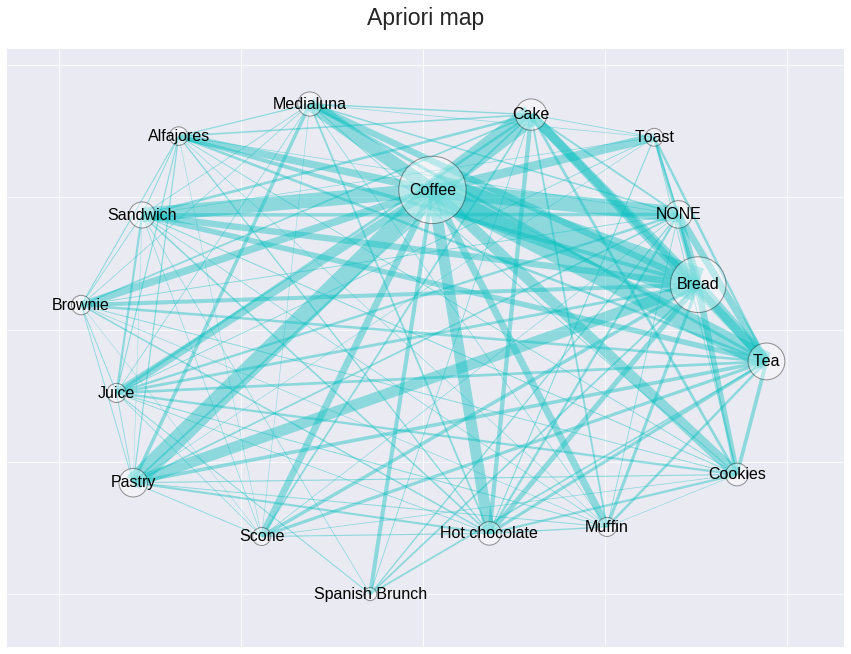

In [14]:
plt.style.use('seaborn-deep')
plt.style.use('seaborn-darkgrid')
fig, ax=plt.subplots(figsize=(15,11))


#rulesを基にインスタンス(GA)を用意
GA=nx.from_pandas_edgelist(rules,source='antecedents',target='consequents')
GA.add_nodes_from([(item, {"count":count}) for item,count in item_count if item in GA])


#空辞書にweightをセット 
for (u,v,d) in list(GA.edges(data=True)):
    d.setdefault("weight",0)


####### edge間のweight設定 ######
for items in lst:
    for node0,node1 in itertools.combinations(items, 2):
        if not GA.has_node(node0) or not GA.has_node(node1):
            continue
        if GA.has_edge(node0, node1):
            GA.get_edge_data(node0, node1)["weight"] += 1
        else:
            GA.add_edge(node0, node1, weight=1)
            
#edgeのweightの域値設定
for (u,v,d) in list(GA.edges(data=True)):
    if d["weight"] <= 10:
        GA.remove_edge(u, v)
        

####### レイアウトインスタンス ######
pos = nx.spring_layout(GA,k=20)


####### node(円)の描写 ######
#円の大きさを調整
node_size = [ d['count']*1 for (n,d) in GA.nodes(data=True)]
#描写
nodes = nx.draw_networkx_nodes(GA, pos, node_color='w',alpha=0.4, node_size=node_size,linewidths=1)
# nodeの外周円の色を設定
nodes.set_edgecolor('black')



####### edge(線)の描写 ######
#線の太さを調整
edge_width = [ d['weight']*0.04 for (u,v,d) in GA.edges(data=True)]
#描写
nx.draw_networkx_edges(GA, pos, alpha=0.4, edge_color='c', width=edge_width)
    
    
####### 表示ラベルの描写 ######
nx.draw_networkx_labels(GA, pos, font_size=16)


plt.rcParams['axes.xmargin'] = 0.1
plt.rcParams['axes.ymargin'] = 0.1
plt.tick_params(labelbottom=False,labelleft=False)
plt.title("Apriori map",ha='center',y=1.03,fontsize=23)
#plt.savefig('works8.png')
plt.show()
